---
title: "The Journey Is the Model: Dynamic Path Analysis in PyMC"
subtitle: "Causal Inference with Time-Varying Effects"
categories: ["path-models", "sem", "causal inference"]
keep-ipynb: true
self-contained: true
draft: false
toc: true
execute: 
  freeze: auto 
  execute: true
  eval: true
jupyter: applied-bayesian-regression-modeling-env
image: 'evolving_dag.png'
author:
    - url: https://nathanielf.github.io/
    - affiliation: PyMC dev
citation: true
---

In [1]:
import pymc as pm
import numpy as np 
import pandas as pd
import arviz as az
import pytensor.tensor as pt
from scipy.interpolate import BSpline
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

If you look to Odysseus on the morning the gates of Troy fell, he is well set up for a happy journey home. He is the architect of victory, his ships are loaded with spoils, and the wind is at his back. Yet, an odyssey can't be completed in a single day and conclusions drawn on the outset rarely survive journey's end. 

When we rely on static snapshots, like a single blood draw or a particular sales campaign, we are watching Odysseus board his ship and guessing how the story ends. We ignore the __consequences emerging in time.__ This is an apt observation with which to begin the year. Will your new year's resolutions, survive the January? This is the kind of question we'll assess here. 

::: {.callout-note icon=false}
### What You'll Learn in This Post
This tutorial demonstrates how to implement Aalen's Dynamic Path Model in PyMC to decompose time-varying causal effects in survival analysis. You'll learn:

- The Theory: Why static snapshots miss the story and how interventions evolve over time.
- The Challenge: Moving from proportional hazards to additive models that allow effects to wax, wane, or reverse
- The Solution: Using B-splines and the "Poisson Bridge" to create a fully Bayesian dynamic path model
- The Application: Replicating the dpasurv R package benchmark and revealing masked mediation effects

**Key Technical Components**:

- Time discretization and B-spline basis construction
- Simultaneous equation systems for mediator and hazard models
- The Softplus link for maintaining positive hazards
- Direct, indirect, and total effect decomposition over time

By the end, you'll be able to track how a New Year's resolution (or any intervention) doesn't just succeed or fail—it transforms through distinct phases, with different mechanisms dominating at different times.
:::

## Interventions and Attenuated Effects: The Theory

To track how intention precedes and predicts evolving outcomes we need a statistical framework that doesn't just record the departure but tracks the entire voyage. Enter **Aalen’s Additive Model**, formulated as a **Dynamic Path Model**. The question is when will we achieve our goals? When will Odysseus get home? How does the risk of attaining our goal vary over time?

While traditional models, like the Cox Proportional Hazards or Accelerated Failure time models, often assume that an intervention’s effect is a constant "multiplier" throughout the study period, Aalen’s approach treats effects as a living process. It allows the impact of a policy or treatment to wax, wane, or even reverse as the narrative unfolds. 

### The Machinery of Change

In a dynamic path system, we decompose the total risk into a series of additive "layers." If we are interested in how an intervention ($X$) works through a mediator ($M$), we model the hazard $\lambda(t)$ as:

$$\lambda(t | X, M) = \alpha_0(t) + \alpha_1(t)X + \alpha_2(t)M$$

Where:

- $\alpha_0(t)$ is the **Baseline Hazard**, representing the background "tension" of the story.
- $\alpha_1(t)$ is the **Time-Varying Direct Effect**, showing how the intervention influences risk at every specific moment.
- $\alpha_2(t)$ is the **Time-Varying Mediator Effect**, capturing how the intermediate variable (the "storm" or the "detour") contributes to the outcome.

All three components are modelled as time-varying functions that distil the effects over time. 

### From Static to Dynamic: A Sequence of DAGs

Standard causal inference often relies on a static Directed Acyclic Graph (DAG) to represent the "rules" of the system. But in a survival context, the DAG itself is dynamic. We can think of the model as a sequence of DAGs—one for each "scene" in our odyssey—where the causal arrows between $X$, $M$, and the Hazard ($\lambda$) strengthen or weaken over time.


We can visualize this "filmstrip" of causality using `networkx`. We have a series of dynamic causal DAGs representing our assumptions of the relationships:


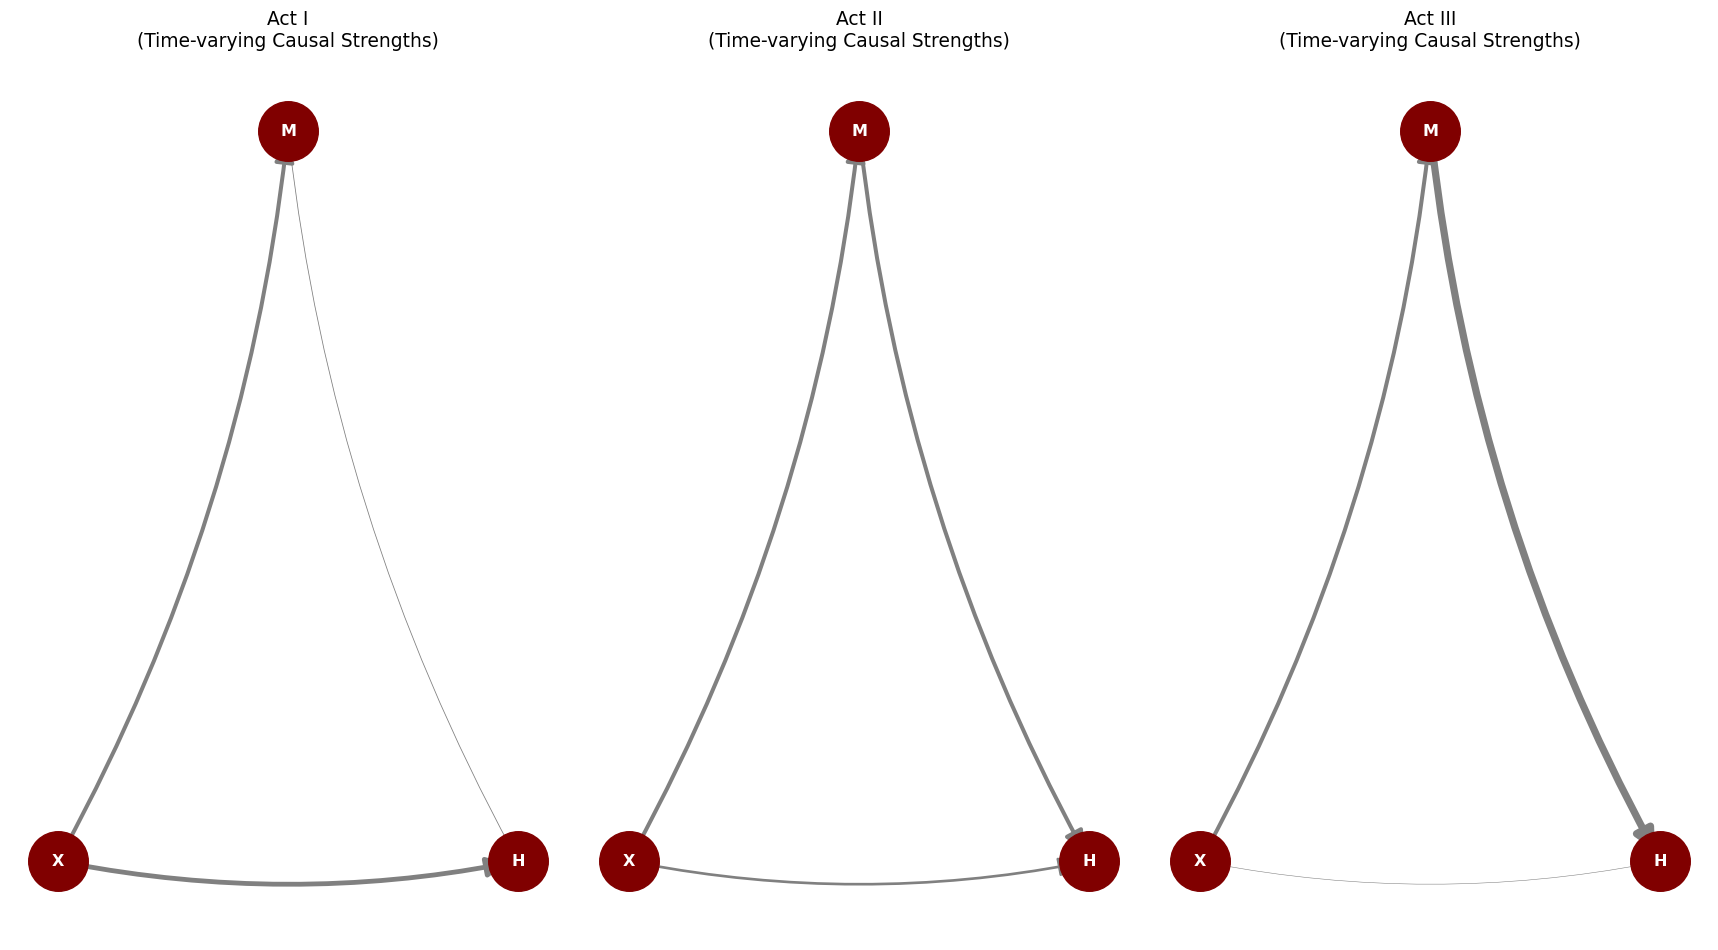

In [2]:
# | code-fold: true
# | output: false
import matplotlib.pyplot as plt
import networkx as nx

def plot_temporal_dag(stages=[0.1, 0.5, 0.9], labels=["Act I", "Act II", "Act III"]):
    fig, axs = plt.subplots(1, 3, figsize=(18, 10))
    
    # Define nodes: Exposure, Mediator, Hazard
    nodes = {'X': (0, 1), 'M': (1, 2), 'H': (2, 1)}
    
    for i, (stage, label) in enumerate(zip(stages, labels)):
        G = nx.DiGraph()
        G.add_nodes_from(nodes.keys())
        
        # We vary the weights to represent alpha_1(t) and alpha_2(t)
        # Act I: Direct effect strong, Mediator weak
        # Act III: Mediator dominates or effects attenuate
        direct_w = 4 * (1 - stage) 
        indirect_w = 6 * stage
        
        edges = [('X', 'H', direct_w), ('X', 'M', 3), ('M', 'H', indirect_w)]
        
        for u, v, w in edges:
            G.add_edge(u, v, weight=w)
            
        pos = nodes
        nx.draw_networkx_nodes(G, pos, ax=axs[i], node_color='maroon', node_size=2000)
        nx.draw_networkx_labels(G, pos, ax=axs[i], font_color='white', font_weight='bold')
        
        # Draw edges with widths corresponding to causal strength
        weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, ax=axs[i], width=weights, 
                               edge_color='gray', arrowsize=30, connectionstyle="arc3,rad=0.1")
        
        axs[i].set_title(f"{label}\n(Time-varying Causal Strengths)", fontsize=14)
        axs[i].axis('off')

    plt.tight_layout()
    return fig

fig = plot_temporal_dag()
fig.savefig("evolving_dag.png")

![](evolving_dag.png)

To truly capture the journey, we cannot look at these variables in isolation. The "storm" ($M$) is not independent—it's a consequence of the path Odysseus chose. We must treat intervention and outcome as a system of simultaneous equations,

::: {.callout-important}

## Dynamic Path Analysis and Causal Interpretation

Dynamic path analysis admits a causal interpretation only under __sequential unconfoundedness__, implied by the assumed temporal DAG. At each time point, conditional on the observed history, there are no unmeasured common causes of the treatment, the mediator process, and the event intensity.

Under this assumption, the time-varying coefficients in the additive hazard model can be interpreted causally: effects of treatment on the mediator, effects of the mediator on the hazard, and their product as a dynamic indirect effect. The path decomposition follows directly from the graph.

If relevant confounders are omitted, or if feedback from the event process into the mediator is not properly lagged, the decomposition remains algebraically valid but loses its causal meaning. The model estimates paths; the DAG and sequential unconfoundedness justify interpreting them as causal.
:::

By solving these equations in tandem, we ensure that the mediator is not just another covariate, but a character with its own backstory, influenced by the intervention even as it influences the final risk.

#### The Mediator Equation (The Will of Poseidon)
Before we can calculate the risk of shipwreck, we must determine how the intervention has altered the environment. We model the mediator as a function of the exposure:

$$M_i = \beta_0 + \beta_{1}(t)X_i + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)$$

Where $\beta_{1}(t)$ tells us how effectively the intervention "recruits" or "triggers" the mediator.

#### 2. The Hazard Equation (The Risk of Shipwreck)
The risk at time $t$ is then a combination of the background noise, the direct path from $X$, and the indirect path from the now-defined $M$:

$$\lambda(t | X, M) = g\left( \alpha_0(t) + \alpha_1(t)X_i + \alpha_2(t)M_i \right)$$

where $g$ is a linking function to translate the covariates into a hazard scale. Taken together these observations should make it clear why this modelling strategy is known as _dynamic path analysis_. We essentially have a structural equation model (SEM) with specific path coefficients that trace out the influence between variables. This means we are no longer ‘controlling for M’ but explicitly modeling how X creates M and how M creates risk. So we also require that we capture the time evolution of these relationships. It's not enough to say of Odysseus that he had good intentions, it all ended well. We lose something if we don't understand the journey.

### Causal Inference and Additive Effects

Aalen's main concern was how to represent mechanisms that unfold in time without forcing them into a proportional straitjacket as in Cox style regressions. In many applied settings, an intervention does not exert a constant relative effect. Instead we act, with effects accumulating, and sometimes attenuated or disappearing over time.

By modeling covariate effects as _increments to risk_, the coefficients themselves become causal estimands. A time-varying coefficient $\alpha_{1}(t)$ answers a concrete question: what is the level of risk attributable to the exposure at time $t$? Once effects are additive, they can be decomposed and recombined. Direct, indirect, and total effects become sums of paths traced through time. The model reads naturally as a time-indexed causal graph with estimable path strengths.

> "We have a sequence of dynamic path models, one for each time t when we collect information. The estimation of each dynamic path model is done by recursive least squares regression as usual in path analysis" - Fosen et al in _"Dynamic path analysis – a new approach to
analyzing time-dependent covariates"_

The central objects in dynamic path analysis are the time-varying regression functions that link treatment, mediator, and survival. In the canonical `dpasurv` formulation, these are the functions $\beta_1(t), \alpha_2(t)$ and $\alpha_1(t)$, which parameterize the direct path from treatment to the mediator, the effect of mediator on the hazard, and the effect of the treatment on the hazard, respectively.

#### Cumulative Effects in `dpasurv`

Dynamic path analysis is concerned not with isolated coefficients, but with how these functions evolve over time. They form the building blocks from which direct, indirect, and total effects are constructed.

Because effects act continuously, interpretation is naturally expressed in cumulative terms. A cumulative coefficient is like a running total of a covariate’s effect on risk — it sums up, over time, how much that treatment or mediator has nudged the chance of an event happening. The **cumulative direct effect** up to time $t$ is defined as

$$\text{cumdir}(t) = \int_0^t \beta_1(s)\, ds,$$

representing the accumulated contribution of the treatment along the direct path to the hazard. In an additive hazards framework like Aalen’s model, we are directly estimating the cumulative coefficient function — the total accumulated effect up to time t, rather than first estimating the instaneous effect $\beta_{1}(t_{i})$ and then summing or integrating it over the index. Similarly, the **cumulative indirect effect** is defined as

$$\text{cumind}(t) = \int_0^t \alpha_1(s)\, \beta_2(s)\, ds,$$

which aggregates the mediated influence of treatment on survival. At each instant, the indirect effect is obtained by multiplying the strength of the treatment–mediator link with the strength of the mediator–hazard link, mirroring the logic of path analysis. A defining feature of dynamic path analysis is that these quantities satisfy an exact analytical decomposition:

$$\text{cumtot}(t) = \text{cumdir}(t) + \text{cumind}(t).$$

This identity holds because the model is additive. The `dpasurv` package demonstrates these decomposition with the following data. 


In [3]:
df = pd.read_csv("aalen_simdata.csv")
df = df[['subject', 'x', 'dose', 'M', 'start', 'stop', 'event']]
df.head()

,subject,x,dose,M,start,stop,event
0,1,0,ctrl,6.74,0,4.00,0
1,1,0,ctrl,6.91,4,8.00,0
2,1,0,ctrl,6.90,8,12.00,0
3,1,0,ctrl,6.71,12,26.00,0
4,1,0,ctrl,6.45,26,46.85,1


The data is an "long format" which is multiple rows per individual `subject` with running values for the state of the treatment indicator `x` and the mediator `M`, and crucially the `even` flag which denotes whether or not the terminal event occured. This is simulated data from the `dpasurv` r package, but the abstract names serve to illustrate the ubiquity of the mediator relationship! Even if you're not Odysseus, it's common knowledge that the Gods laugh when men make plans. Mediator structures are everywhere, and we will show how to handle them with dynamic path analysis.

### Replicating the `dpasurv` Benchmark

The figure below shows the cumulative direct, indirect, and total effects estimated by dpasurv from our simulated dataset. The direct effect (left panel) traces the immediate influence of the treatment on the outcome, while the indirect effect (middle panel) captures the pathway mediated through $M$. The total effect (right panel) is simply the sum of the two.

![](dpasurv_benchmark.png)

Notice the step-like patterns—characteristic of `dpasurv`, which sums contributions at discrete event times. As events become sparse, confidence intervals widen.

The main pattern we're seeing here is that the direct effect of `x` in the first panel. The curve begins to dip below zero almost immediately and maintains a consistent downward slope, meaning the negative cumulative effect indicates that the intervention itself is actively __reducing the hazard.__. This is good, but contrast it with slight emerging effect in central panel. For the first 100 days, the mediator is a bystander. It is either not being triggered by the intervention or has no impact on survival. Around Day 100, the curve "breaks" and spikes upward. This represents a __positive contribution to the hazard.__ The combination of the total effects reflects this too. The total effect become less negative (closer to zero) after Day 100. This tells us that while the intervention is still helpful overall, its net benefit is being attenuated by the mediator.


The `dpasurv` data is simulated to capture precisely this delayed impact, and these the patterns we will try and replicate in our Bayesian dynamic path model. Having established the theoretical architecture above, we now face the practical challenge of implementation. The elegance of Aalen's additive model conceals three technical hurdles: discretizing continuous time, parameterizing smooth effects, and ensuring positive hazards. We'll tackle each in turn


## Exploring the Data:

Let's begin by looking at a simple cross-cut. 


In [4]:
df.groupby(['x', 'dose'])[['event', 'M']].agg(['mean', 'sum'])

event             M         
            mean sum      mean      sum
x dose                                 
0 ctrl  0.164179  66  6.996915  2812.76
1 high  0.119205  54  8.081589  3660.96
  low   0.139037  52  7.302620  2731.18

which shows a higher incidence of the event in the control group than the treatment group, but even within the treatment it seems a higher dosage is linked to lower incident rate. The size of the groups for each treatment level are approximately equal, but ignoring the dosage we see more people in the treatment group than the control.


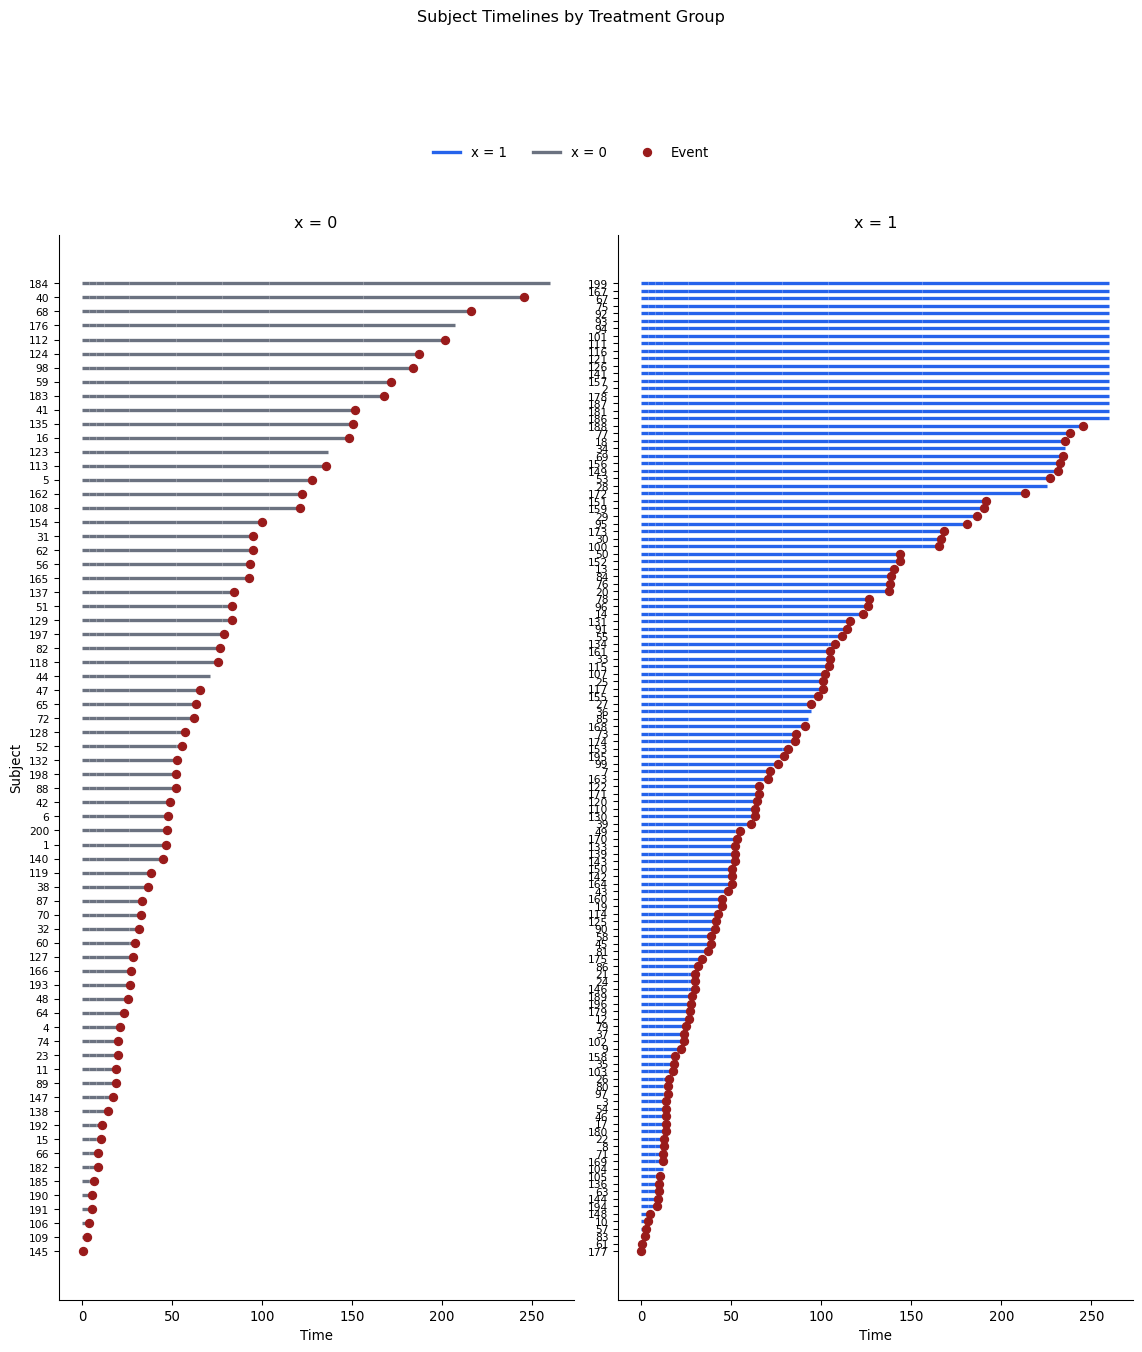

In [5]:
# | code-fold: true
# | output: false
# | echo: false

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -----------------------
# Color palette (muted & clean)
# -----------------------
COLOR_X0 = "#6B7280"    # muted slate gray
COLOR_X1 = "#2563EB"    # soft rich blue
EVENT_COLOR = "#991B1B" # deep muted red

# -----------------------
# Split subject ordering by treatment group
# -----------------------
subject_info = (
    df.groupby('subject')
      .agg(
          x=('x', 'first'),
          max_stop=('stop', 'max')
      )
)

subject_info_0 = (
    subject_info[subject_info['x'] == 0]
    .sort_values('max_stop')
)

subject_info_1 = (
    subject_info[subject_info['x'] == 1]
    .sort_values('max_stop')
)

subjects_0 = subject_info_0.index.tolist()
subjects_1 = subject_info_1.index.tolist()

subject_to_y_0 = {s: i for i, s in enumerate(subjects_0)}
subject_to_y_1 = {s: i for i, s in enumerate(subjects_1)}

# -----------------------
# Create side-by-side plots
# -----------------------
fig, axes = plt.subplots(
    ncols=2,
    figsize=(12, 0.1 * max(len(subjects_0), len(subjects_1))),
    sharex=True
)

ax0, ax1 = axes

# -----------------------
# Plot x = 0 group
# -----------------------
for _, row in df[df['x'] == 0].iterrows():
    y = subject_to_y_0[row['subject']]

    ax0.hlines(
        y=y,
        xmin=row['start'],
        xmax=row['stop'],
        color=COLOR_X0,
        linewidth=2.5
    )

    if row['event'] == 1:
        ax0.plot(
            row['stop'],
            y,
            marker='o',
            color=EVENT_COLOR,
            markersize=6,
            zorder=3
        )

ax0.set_yticks(range(len(subjects_0)))
ax0.set_yticklabels(subjects_0)
ax0.set_title("x = 0")
ax0.set_ylabel("Subject")

# -----------------------
# Plot x = 1 group
# -----------------------
for _, row in df[df['x'] == 1].iterrows():
    y = subject_to_y_1[row['subject']]

    ax1.hlines(
        y=y,
        xmin=row['start'],
        xmax=row['stop'],
        color=COLOR_X1,
        linewidth=2.5
    )

    if row['event'] == 1:
        ax1.plot(
            row['stop'],
            y,
            marker='o',
            color=EVENT_COLOR,
            markersize=6,
            zorder=3
        )

ax1.set_yticks(range(len(subjects_1)))
ax1.set_yticklabels(subjects_1)
ax1.set_title("x = 1")

# -----------------------
# Shared formatting & polish
# -----------------------
for ax in axes:
    ax.set_xlabel("Time")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

# -----------------------
# Legend
# -----------------------
legend_elements = [
    Line2D([0], [0], color=COLOR_X1, lw=2.5, label='x = 1'),
    Line2D([0], [0], color=COLOR_X0, lw=2.5, label='x = 0'),
    Line2D([0], [0], marker='o', color=EVENT_COLOR,
           lw=0, label='Event', markersize=6),
]

ax0.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)

fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.98)
)

fig.suptitle(
    "Subject Timelines by Treatment Group",
    y=1.08
)

plt.tight_layout(rect=[0, 0, 1, 0.95])

fig.savefig("timelines_plot.png")

![](timelines_plot.png)

The plot shows the timelines and the occurence of incidents for each treatment group. In most cases we see the terminal event occurs for each subject. Next we'll try and pull out the differences due to dosage.


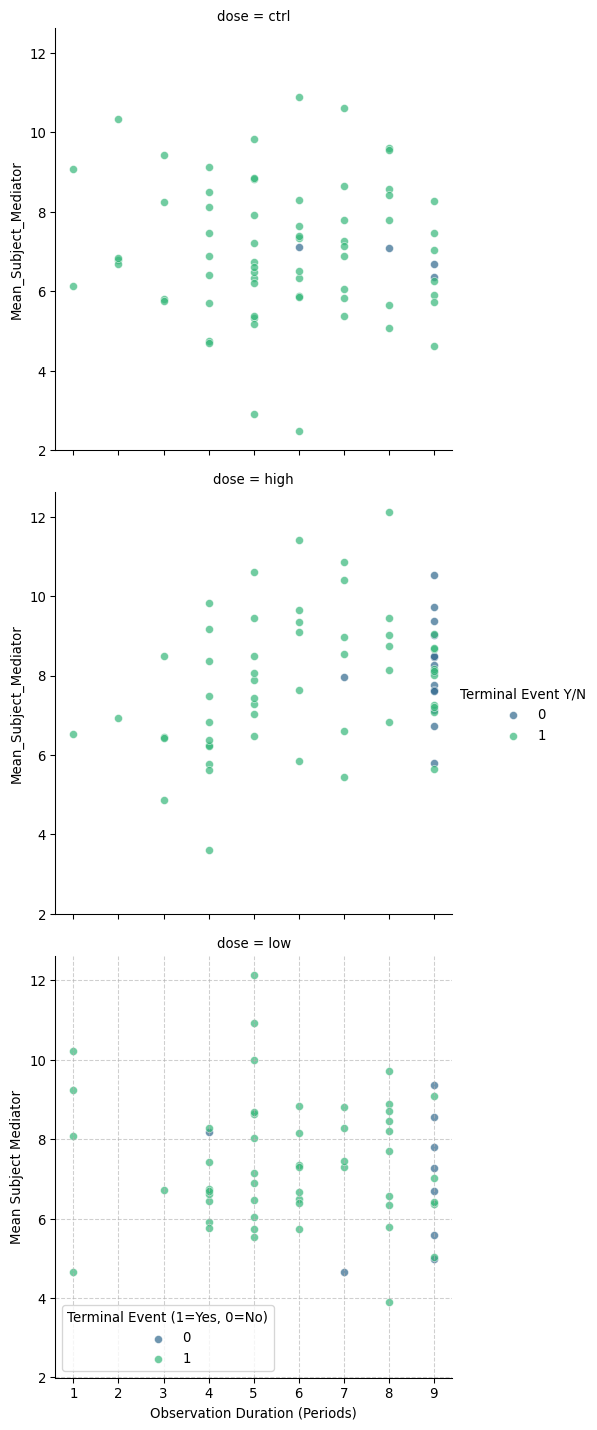

In [6]:
# | output: false
# | code-fold: true

mean_levels = df.groupby('subject')[['M', 'event', 'x', 'dose']].agg({'event': 'sum', 'M': 'mean', 'x': 'count', 'dose': 'first'}).rename({'M':'Mean_Subject_Mediator', 'x': 'Observation Periods', 'event': 'Terminal Event Y/N'}, axis=1)
mean_levels

# Assuming your dataframe is named 'df'
g = sns.FacetGrid(mean_levels, row="dose", hue="Terminal Event Y/N", palette='viridis', height=5)
g.map(sns.scatterplot, "Observation Periods", "Mean_Subject_Mediator", alpha=0.7)
g.add_legend()

plt.xlabel('Observation Duration (Periods)')
plt.ylabel('Mean Subject Mediator')
plt.legend(title='Terminal Event (1=Yes, 0=No)')
plt.grid(True, linestyle='--', alpha=0.6)
fig = plt.gcf()
fig.savefig("Crosscut_MeanMediator.png")

![](Crosscut_MeanMediator.png)

This plot shows in a crude way how time is the primary driver of the outcome with most terminal events clustering to the right longer treatment durations. There is also some visual evidence that higher mediator values have more terminal outcomes on the right hand side of the plot. But also, that higher dosage appears to have more surviving cases. But to really partial out these effects we need a more disciplined modelling approach. 

With these exploratory insights in hand, we now turn to the technical implementation.

### Data Preparation: Discretising time 

This function restructures the original start–stop survival data into a finite set of time bins, where each bin corresponds to a unique (start, stop) interval observed in the data representation. By assigning every subject–interval to a discrete time index, we obtain a representation in which all time-varying quantities are constant within bins but allowed to vary across bins.

We discretise time in to sequential blocks of an evolving narrative. Rather than treating regression coefficients as fully continuous functions of time, we work with piecewise constant approximations indexed by these bins. Conceptually, this mirrors the classical Aalen estimator, where coefficient paths only change at observed event times and remain flat in between. A sequence of chapters in our odyssey. 


In [7]:
def prepare_aalen_dpa_data(
    df,
    subject_col="subject",
    start_col="start",
    stop_col="stop",
    event_col="event",
    x_col="x",
    m_col="M",
):
    """
    Prepare Andersen–Gill / Aalen dynamic path data for PyMC.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format start–stop survival data
    subject_col : str
        Subject identifier
    start_col, stop_col : str
        Interval boundaries
    event_col : str
        Event indicator (0/1)
    x_col : str
        Exposure / treatment
    m_col : str
        Mediator measured at interval start

    Returns
    -------
    dict
        Dictionary of numpy arrays ready for PyMC
    """

    df = df.copy()

    # -------------------------------------------------
    # 1. Basic quantities
    # -------------------------------------------------
    df["dt"] = df[stop_col] - df[start_col]

    if (df["dt"] <= 0).any():
        raise ValueError("Non-positive interval lengths detected.")

    N = df[event_col].astype(int).values
    Y = np.ones(len(df), dtype=int)  # Andersen–Gill at-risk indicator

    # -------------------------------------------------
    # 2. Time-bin indexing (piecewise-constant effects)
    # -------------------------------------------------
    bins = (
        df[[start_col, stop_col]]
        .drop_duplicates()
        .sort_values([start_col, stop_col])
        .reset_index(drop=True)
    )
    bins["bin_idx"] = np.arange(len(bins))

    df = df.merge(
        bins,
        on=[start_col, stop_col],
        how="left",
        validate="many_to_one"
    )

    bin_idx = df["bin_idx"].values
    n_bins = bins.shape[0]

    # -------------------------------------------------
    # 3. Center covariates (important for Aalen models)
    # -------------------------------------------------
    df["x_c"] = df[x_col]
    df["m_c"] = df[m_col] - df[m_col].mean()

    x = df["x_c"].values
    m = df["m_c"].values

    # -------------------------------------------------
    # 4. Predictable mediator (lag within subject)
    # -------------------------------------------------
    df = df.sort_values([subject_col, start_col])

    df["m_lag"] = (
        df.groupby(subject_col)["m_c"]
          .shift(1)
          .fillna(0.0)
    )

    m_lag = df["m_lag"].values

    df["I_low"]  = (df["dose"] == "low").astype(int)
    df["I_high"] = (df["dose"] == "high").astype(int)

    # -------------------------------------------------
    # 5. Assemble output
    # -------------------------------------------------
    data = {
        "bins": bins,     # required discretisation
        "df_long": df     # feature set for time-varying features
    }

    return data


In addition to defining the time bins, the function constructs predictable covariates—most notably a lagged mediator within subject—and performs the centering required for additive hazard models.


In [8]:
data = prepare_aalen_dpa_data(df)
df_long = data['df_long']
df_long[['subject', 'x', 'dose', 'm_c', 'm_lag', 'event', 'dt', 'bin_idx']].head(14)

,subject,x,dose,m_c,m_lag,event,dt,bin_idx
0,1,0,ctrl,-0.749748,0.000000,0,4.00,7
1,1,0,ctrl,-0.579748,-0.749748,0,4.00,13
2,1,0,ctrl,-0.589748,-0.579748,0,4.00,23
3,1,0,ctrl,-0.779748,-0.589748,0,14.00,53
4,1,0,ctrl,-1.039748,-0.779748,1,20.85,81
5,2,1,high,-1.379748,0.000000,0,4.00,7
6,2,1,high,-1.209748,-1.379748,0,4.00,13
7,2,1,high,-0.449748,-1.209748,0,4.00,23
8,2,1,high,-0.559748,-0.449748,0,14.00,53
9,2,1,high,0.370252,-0.559748,0,26.00,89


Once time has been discretised into bins, the remaining challenge is how to allow effects to evolve smoothly across those bins. Rather than treating each interval as completely unrelated to its neighbours, we introduce a spline-based representation that ties adjacent time bins together. 

### Spline Functions in Time

This code lets us approximate continuously varying coefficient functions using a flexible but structured set of basis functions defined over the discretised time axis. 


In [9]:
def create_bspline_basis(n_bins, n_knots=10, degree=3):
    """
    Create B-spline basis functions for smooth time-varying effects.
    
    Parameters
    ----------
    n_bins : int
        Number of time bins
    n_knots : int
        Number of internal knots (fewer = smoother)
    degree : int
        Degree of spline (3 = cubic, recommended)
    
    Returns
    -------
    basis : np.ndarray
        Matrix of shape (n_bins, n_basis) with basis function values
    """
    # Create knot sequence
    # Internal knots equally spaced across time range
    internal_knots = np.linspace(0, n_bins-1, n_knots)
    
    # Add boundary knots (repeated degree+1 times for clamped spline)
    knots = np.concatenate([
        np.repeat(internal_knots[0], degree),
        internal_knots,
        np.repeat(internal_knots[-1], degree)
    ])
    
    # Number of basis functions
    n_basis = len(knots) - degree - 1
    
    # Evaluate each basis function at each time point
    t = np.arange(n_bins, dtype=float)
    basis = np.zeros((n_bins, n_basis))
    
    for i in range(n_basis):
        # Create coefficient vector (indicator for basis i)
        coef = np.zeros(n_basis)
        coef[i] = 1.0
        
        # Evaluate B-spline
        spline = BSpline(knots, coef, degree, extrapolate=False)
        basis[:, i] = spline(t)
    
    return basis

n_knots = 10
n_bins = data['bins'].shape[0]
basis = create_bspline_basis(n_bins, n_knots=n_knots, degree=3)
n_cols = basis.shape[1]
basis_df = pd.DataFrame(basis, columns=[f'feature_{i}' for i in range(n_cols)])
basis_df.head(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.863149,0.133496,0.003337,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.739389,0.247518,0.012946,0.000146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.628064,0.343219,0.028223,0.000494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.528515,0.421749,0.048566,0.001170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.440083,0.484261,0.073370,0.002286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.362110,0.531908,0.102032,0.003950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.293939,0.565840,0.133949,0.006272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.234909,0.587211,0.168518,0.009362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.184365,0.597171,0.205134,0.013330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In Aalen’s additive model, the primary objects of interest are _cumulative regression coefficients_: time-indexed functions that accumulate the effect of a covariate on the hazard as time progresses. Empirically, these functions are only identified at a discrete set of time points and are typically visualised as step functions that jump at event times.

Our discretisation of time into bins provides a natural scaffold for working with these cumulative effects. Instead of letting each time bin jump independently (which produces those jagged `dpasurv` plots) we smooth the path with splines. Weaving a thread through the jagged sequence. 


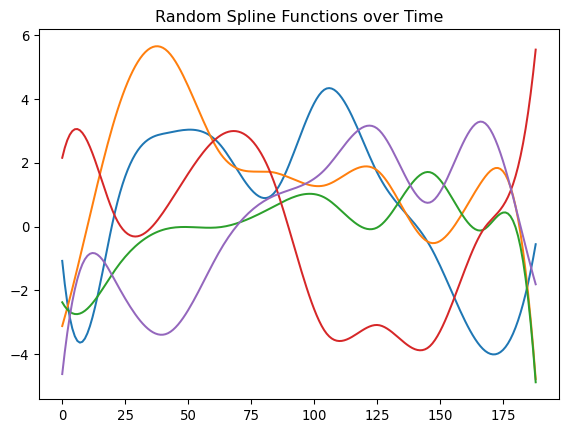

In [10]:
# | output: false
fig, ax = plt.subplots()
ax.set_title("Random Spline Functions over Time")
for i in range(5):
    betas_spline = np.random.normal(0, 3, 12)
    np.dot(basis_df, betas_spline)
    ax.plot(np.dot(basis_df, betas_spline))

fig.savefig("random_splines.png")

![](random_splines.png)

The figure above illustrates this idea. Each curve corresponds to a different random draw of spline coefficients, combined with the same underlying basis. Although these curves are generated without reference to the data, they all resemble plausible cumulative coefficient paths: continuous, gradually evolving over time, and free of the abrupt jumps that arise when coefficients are estimated independently at each event time.

This perspective is important conceptually. Rather than viewing cumulative coefficients as the result of summing many instantaneous effects, we treat them as primary objects to be estimated directly, with smoothness acting as a regularising assumption. In the next section, we will show how this spline-based representation is embedded into a full probabilistic model.

## Survival Models and their Likelihood

We will adapt a Poisson likelihood to estimate survival times. The most significant advantage of this approach over pseudo-likelihood schemes is that it **replaces the "nuisance" of the baseline hazard with an explicit parameterization of time.** By discretizing the timeline into a finite index of bins, we transform a nebulous, continuous survival function into a structured set of parameters that a Bayesian sampler can navigate.

In our discrete-time framework, the baseline hazard is no longer hidden background noise. Instead, it is parameterized via the discrete index $t$, allowing the model to "see" exactly how the background risk changes from the start of the study to its conclusion. This clear mapping provides a well-defined probability distribution for every observed data point:

$$d_{it} \sim \text{Poisson}(\lambda(t))$$
$$\lambda(t) = Y_{it} \cdot \Delta t \cdot \lambda_{it}$$

Where:

- $d_{it}$ is the event indicator (0 or 1).
- $Y_{it}$ is the "at-risk" indicator.
- $\Delta t$ is the duration of the time bin.
- $\lambda_{it}$ is the cumulative hazard.

It may seem odd to approximate binary events with a "counting" distribution, but viewed at a distance binary events are just counts capped at 1. 

#### From Ordering to Intensities
Pseudo-likelihoods primarily care about the ordering of events rather than the absolute scale of time. They effectively discard the actual duration of time between events in favour of focusing on who failed before whom. By parameterizing time via a discrete index, we move from mere rankings to **intensities**. We model the actual "velocity" of risk in every interval, which allows us to place **Bayesian priors** on the baseline hazard itself (such as Random Walks or Splines). This enforces a "temporal smoothness" that prevents the background risk from jumping erratically. This is the requirement for narrative coherence in Odysseus' journey. 

It is common in survival analysis to estimate covariate effects using a **partial likelihood**, which identifies regression coefficients without specifying the baseline hazard. In its canonical form, this likelihood depends only on the ordering of event times,

$$
L_p(\beta) = \prod_{i:d_i=1} 
\frac{\exp(X_i \beta)}{\sum_{j \in R(t_i)} \exp(X_j \beta)},
$$

and does not define a joint probability model for the observed survival times themselves. As a result, the hazard function and cumulative risk must be reconstructed after estimation rather than arising from a generative model of time-to-event data.

For the purposes of dynamic path analysis, this is limiting. The approach developed here requires a likelihood that generates event times, accommodates time-varying effects, and allows direct simulation of hazards and counterfactual trajectories. We therefore adopt a full likelihood representation, which makes these quantities explicit and enables coherent Bayesian inference.

The Poisson likelihood specification solves this by reframing survival as a counting process over discretized time bins. By mapping the survival hazard to the mean of a Poisson distribution, we transition from an incomplete pseudo-likelihood to a full, generative likelihood:

$$d_{it} \sim \text{Poisson}(\lambda(t)), \quad \text{where} \quad \lambda(t) = Y_{it} \cdot \Delta t \cdot \lambda_{it}$$

This transformation turns the baseline hazard into an explicit, time-indexed parameter rather than a nuisance to be factored out. This structure is perfectly suited for Bayesian modeling; it provides a differentiable likelihood that allows the baseline and time-varying effects to be estimated simultaneously via MCMC, while enabling posterior predictive simulations that the partial likelihood approach cannot natively support.


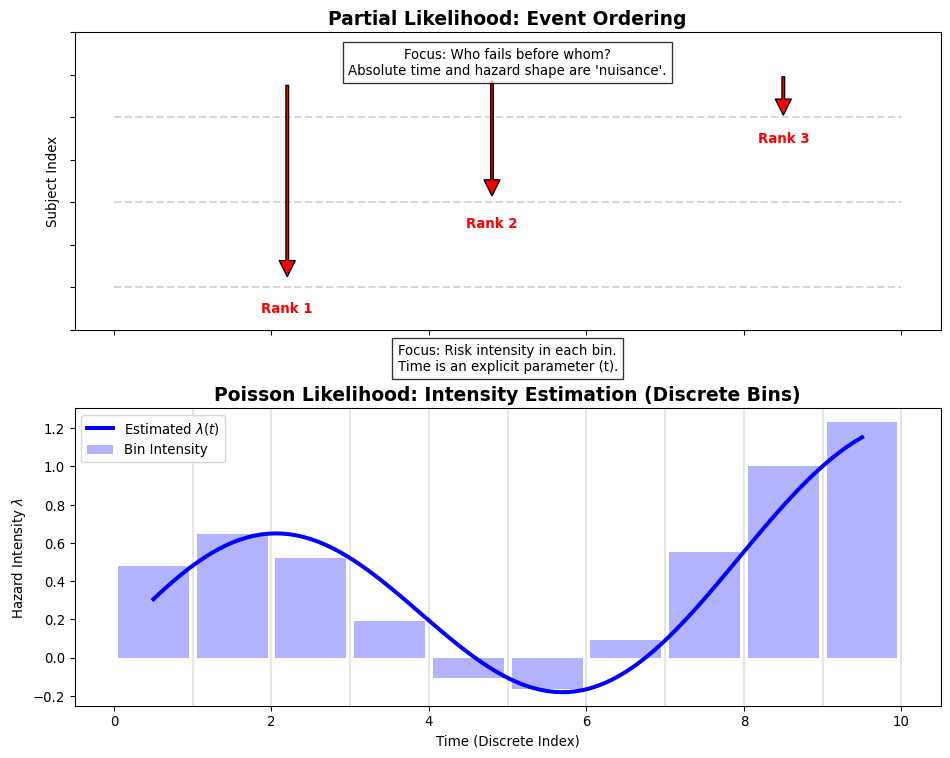

In [11]:
# | code-fold: true
# | output: false

import matplotlib.pyplot as plt
import numpy as np

# Setup data
time_bins = np.arange(1, 11)
baseline_hazard = 0.1 * np.exp(0.2 * time_bins) + 0.5 * np.sin(0.8 * time_bins)
event_times = [2.2, 4.8, 8.5]
event_ranks = [1, 2, 3]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.subplots_adjust(hspace=0.3)

# --- Panel 1: Partial Likelihood (Ordering) ---
ax1.set_title("Partial Likelihood: Event Ordering", fontsize=14, fontweight='bold')
ax1.hlines([1, 2, 3], 0, 10, colors='gray', linestyles='--', alpha=0.3)
for i, et in enumerate(event_times):
    ax1.annotate('', xy=(et, i+1), xytext=(et, 3.5),
                 arrowprops=dict(facecolor='red', shrink=0.05, width=2))
    ax1.text(et, i+0.7, f"Rank {event_ranks[i]}", color='red', ha='center', fontweight='bold')

ax1.set_ylabel("Subject Index")
ax1.set_ylim(0.5, 4)
ax1.set_yticklabels([])
ax1.text(5, 3.5, "Focus: Who fails before whom?\nAbsolute time and hazard shape are 'nuisance'.", 
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

# --- Panel 2: Poisson Intensity (Explicit Parameterization) ---
ax2.set_title("Poisson Likelihood: Intensity Estimation (Discrete Bins)", fontsize=14, fontweight='bold')

# Draw the bins
for b in time_bins:
    ax2.axvline(b, color='black', alpha=0.1, linestyle='-')
    ax2.bar(b-0.5, baseline_hazard[b-1], width=0.9, alpha=0.3, color='blue', label='Bin Intensity' if b==1 else "")

# Smooth hazard curve (the "Explicit Parameter")
x_smooth = np.linspace(0.5, 9.5, 100)
y_smooth = 0.1 * np.exp(0.2 * x_smooth) + 0.5 * np.sin(0.8 * x_smooth)
ax2.plot(x_smooth, y_smooth, color='blue', linewidth=3, label=r'Estimated $\lambda(t)$')

ax2.set_xlabel("Time (Discrete Index)")
ax2.set_ylabel(r"Hazard Intensity $\lambda$")
ax2.legend()
ax2.text(5, 1.5, "Focus: Risk intensity in each bin.\nTime is an explicit parameter (t).", 
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.tight_layout()

fig.savefig("poisson_approximation.png")


![](poisson_approximation.png)


The Poisson bridge treats time as an **explicit covariate** rather than a nuisance to be conditioned away. By mapping the hazard to a discrete index, we gain a "universal currency" of probability. This allows the baseline risk, the treatment effects, and the mediated paths to all live in the same mathematical space, estimated simultaneously through a single likelihood formulation. The Poisson formulation matters causally because it lets us specify a full data-generating process consistent with the DAG.


In [12]:
# | output: false

def make_model(data, basis, sample=True, observed=True): 
    df_long = data['df_long'].copy()
    n_basis = basis.shape[1]
    n_obs = data['df_long'].shape[0]
    time_bins = data['bins']['bin_idx'].values
    b = df_long['bin_idx']

    observed_mediator = df_long["m_c"].values
    observed_events = df_long['event'].astype(int).values
    observed_treatment = df_long['x'].astype(int).values
    observed_mediator_lag = df_long['m_lag'].values

    coords = {'tv': ['intercept', 'direct', 'mediator'], 
            'splines': ['spline_f_{i}' for i in range(n_basis)], 
            'obs': range(n_obs), 
            'time_bins': time_bins}

    with pm.Model(coords=coords) as aalen_dpa_model:

        trt = pm.Data("trt", observed_treatment, dims="obs")
        med = pm.Data("mediator", observed_mediator, dims="obs")
        med_lag = pm.Data("mediator_lag", observed_mediator_lag, dims="obs")
        events = pm.Data("events", observed_events, dims="obs")
        I_low  = pm.Data("I_low",  df_long["I_low"].values,  dims="obs")
        I_high = pm.Data("I_high", df_long["I_high"].values, dims="obs")
        dt = pm.Data("duration", df_long['dt'].values, dims='obs')
        ## because our long data format has a cell per obs
        at_risk = pm.Data("at_risk", np.ones(len(observed_events)), dims="obs")
        basis_ = pm.Data("basis", basis, dims=('time_bins', 'splines') )

        # -------------------------------------------------
        # 1. B-spline coefficients for HAZARD model
        # -------------------------------------------------
        # Prior on spline coefficients
        # Smaller sigma = less wiggliness
        # Random Walk 1 (RW1) Prior for coefficients
        # This is the Bayesian version of the smoothing penalty in R's 'mgcv' or 'timereg'
        sigma_smooth = pm.Exponential("sigma_smooth", [1, 1, 1], dims='tv')
        beta_raw = pm.Normal("beta_raw", 0, 1, dims=('splines', 'tv'))

        # Cumulative sum makes it a Random Walk
        # This ensures coefficients evolve smoothly over time
        coef_alpha = pm.Deterministic("coef_alpha", pt.cumsum(beta_raw * sigma_smooth, axis=0), dims=('splines', 'tv'))

        # Construct smooth time-varying functions
        alpha_0_t = pt.dot(basis_, coef_alpha[:, 0])
        alpha_1_t = pt.dot(basis_, coef_alpha[:, 1])
        alpha_2_t = pt.dot(basis_, coef_alpha[:, 2])
        
        # -------------------------------------------------
        # 2. B-spline coefficients for MEDIATOR model
        # -------------------------------------------------
        sigma_beta_smooth = pm.Exponential("sigma_beta_smooth", 0.1)
        beta_raw = pm.Normal("beta_raw_m", 0, 1, dims=('splines'))
        coef_beta = pt.cumsum(beta_raw * sigma_beta_smooth)
        
        beta_t = pt.dot(basis_, coef_beta)

        # -------------------------------------------------
        # 3. Mediator model (A path: x → M)
        # -------------------------------------------------
        sigma_m = pm.HalfNormal("sigma_m", 1.0)
        
        # Autoregressive component
        rho = pm.Beta("rho", 2, 2)
        
        mu_m = beta_t[b] * trt + rho * med_lag

        pm.Normal(
            "obs_m",
            mu=mu_m,
            sigma=sigma_m,
            observed=med,
            dims='obs'
        )

        # -------------------------------------------------
        # 4. Hazard model (direct + B path)
        # -------------------------------------------------
        beta_low  = pm.Normal("beta_low",  0, 0.1)
        beta_high = pm.Normal("beta_high", 0, 0.1)
        # Log-additive hazard
        log_lambda_t = (alpha_0_t[b] 
                        + alpha_1_t[b] * trt # direct effect
                        + alpha_2_t[b] * med  # mediator effect
                        + beta_low  * I_low
                        + beta_high * I_high
        )
        
        # Expected number of events
        time_at_risk = at_risk * dt
        Lambda = time_at_risk * pm.math.log1pexp(log_lambda_t)

        if observed:
            pm.Poisson(
                "obs_event",
                mu=Lambda,
                observed=events, 
                dims='obs'
            )
        else: 
            pm.Poisson(
                "obs_event",
                mu=Lambda,
                dims='obs'
            )

        # -------------------------------------------------
        # 5. Causal path effects
        # -------------------------------------------------
        # Store time-varying coefficients
        pm.Deterministic("alpha_0_t", alpha_0_t, dims='time_bins')
        pm.Deterministic("alpha_1_t", alpha_1_t, dims='time_bins')  # direct effect
        pm.Deterministic("alpha_2_t", alpha_2_t, dims='time_bins')  # B path
        pm.Deterministic("beta_t", beta_t, dims='time_bins')        # A path
        
        # Cumulative direct effect
        cum_de = pm.Deterministic(
            "tv_direct_effect",
            alpha_1_t, 
            dims='time_bins'
        )

        # Cumulative indirect effect (product of paths)
        cum_ie = pm.Deterministic(
            "tv_indirect_effect",
            beta_t * alpha_2_t, 
            dims='time_bins'
        )

        # Total effect
        cum_te = pm.Deterministic(
            "tv_total_effect",
            cum_de + cum_ie,
            dims='time_bins'
        )

        pm.Deterministic('tv_baseline_hazard', pm.math.log1pexp(alpha_0_t), 
            dims='time_bins')

        pm.Deterministic('tv_hazard_with_exposure', pm.math.log1pexp(alpha_0_t + alpha_1_t), 
            dims='time_bins')

        pm.Deterministic(
        "tv_RR",
        pm.math.log1pexp(alpha_0_t + alpha_1_t) /
        pm.math.log1pexp(alpha_0_t),
        dims="time_bins"
        )

        # -------------------------------------------------
        # 6. Sample
        # -------------------------------------------------
        if sample:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(
                draws=2000,
                tune=2000,
                target_accept=0.95,
                chains=4,
                nuts_sampler="numpyro",
                random_seed=42,
                init="adapt_diag", 
                idata_kwargs={"log_likelihood": True}
            ))
            idata.extend(pm.sample_posterior_predictive(idata))
    
    return aalen_dpa_model, idata

basis = create_bspline_basis(n_bins, n_knots=12, degree=3)
aalen_dpa_model, idata_aalen =  make_model(data, basis)

Sampling: [beta_high, beta_low, beta_raw, beta_raw_m, obs_event, obs_m, rho, sigma_beta_smooth, sigma_m, sigma_smooth]


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [obs_event, obs_m]


Output()

### The Softplus Link: Preserving Aalen's Additivity

In our `PyMC` implementation, the core challenge of an **Additive Hazards** model is ensuring that the hazard intensity $\lambda(t)$ remains strictly positive. While Aalen's original formulation often struggled with this constraint (sometimes requiring hard clipping at zero), our model utilizes the **Softplus link** (`pm.math.log1pexp`) to provide a robust, differentiable solution.

::: {.callout-note}
### The Softplus Link

The Softplus function, implemented via `pm.math.log1pexp(x)`, is defined as:

$$f(x) = \ln(1 + \exp(x))$$

In the context of this survival model, it serves as a smooth link function that transforms the linear combination of effects into a strictly positive hazard intensity. Unlike a hard truncation at zero, which creates non-differentiable "corners" that hinder NUTS sampling, the Softplus function provides a continuous manifold. It allows the additive components—the baseline $\alpha_0(t)$, the direct effect $\alpha_1(t)$, and the mediator effect $\alpha_2(t)$—to fluctuate freely while ensuring the resulting Poisson mean $\lambda(t)$ is always physically plausible ($> 0$).

:::

### Implementation Summary
We used our splines and random walk parameterisation to represent time-varying hazard intensities and then preserved the additive structure by using the softplus link. Strictly speaking, this is no longer an identity-link Aalen model; it is a smooth, monotone transformation chosen for computational stability. The causal interpretation relies on monotonicity, not exact linearity. By defining `Lambda = time_at_risk * pm.math.log1pexp(log_lambda_t)`, we have created a generative model where the total hazard is the sum of time-varying intensities. This allows for a clean decomposition of causal paths:

* **Direct Intensity:** $\alpha_{1}(t)$ (the time-varying coefficient for treatment)
* **Indirect Intensity:** $\beta_{1}(t) \cdot \alpha_{2}(t)$ (the product of the $A$ and $B$ paths)

This structure is perfectly suited for Bayesian modeling, providing a "well-behaved" likelihood that handles the Aalen additivity while remaining amenable to MCMC. We can see the model structure illustrated in the `PyMC` graph. 


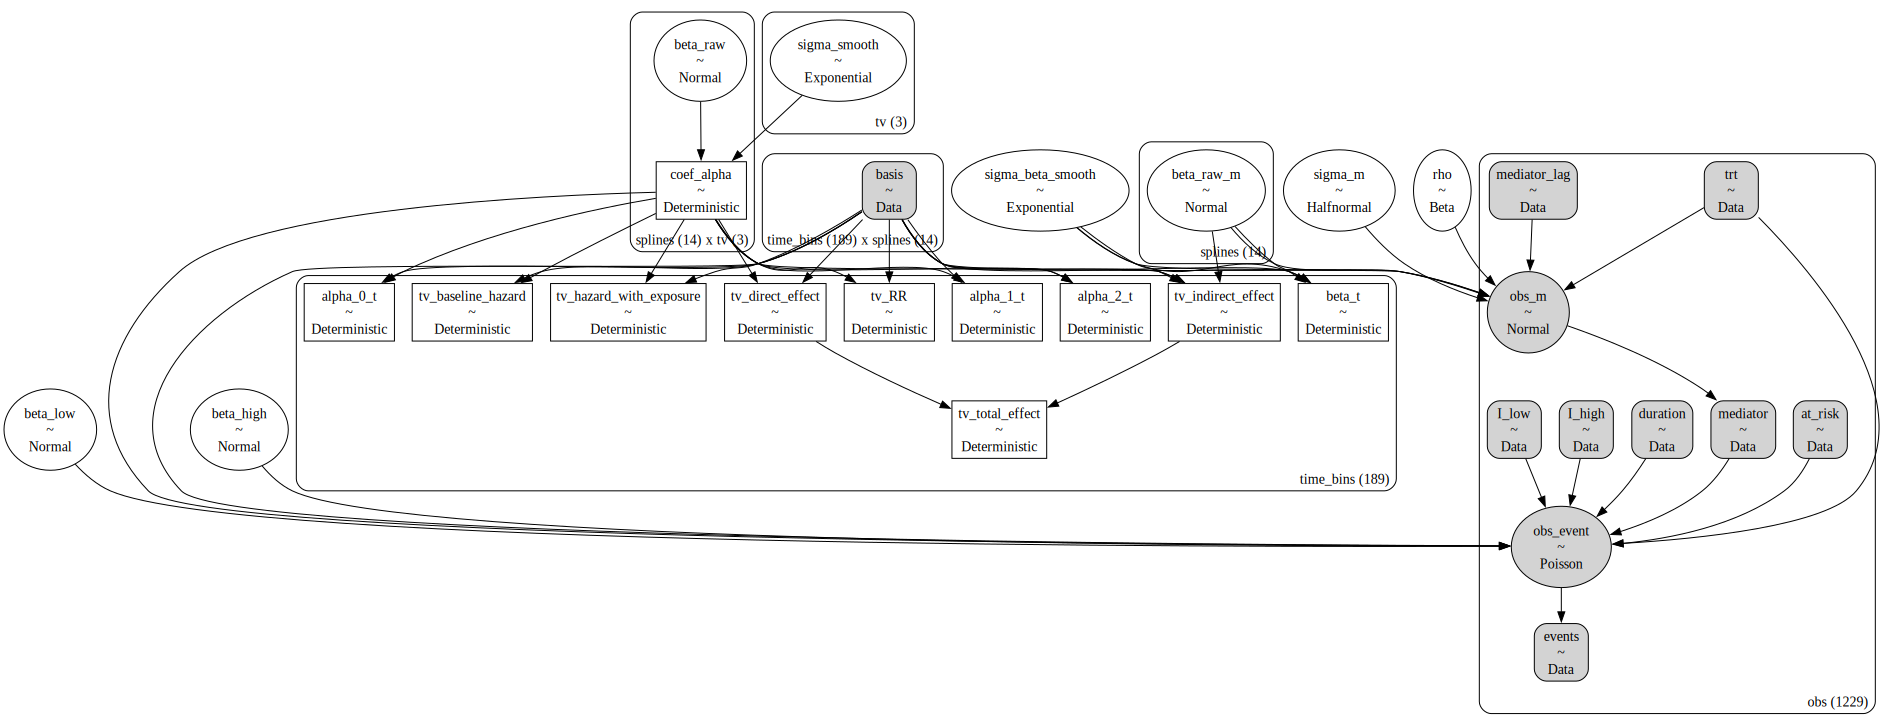

In [13]:
pm.model_to_graphviz(aalen_dpa_model)

## Evaluating the Dynamic Paths Analysis

The use of B-splines to model time-varying effects introduces a critical hyperparameter: the number of knots. The knots determine the "wiggliness" or flexibility of the recovered hazard paths. To ensure the causal conclusions are not artifacts of an underfit or overfit baseline, we perform a sensitivity analysis by varying the knot density and comparing the models using Leave-One-Out Cross-Validation (LOO). This will help us choose how to chart Odysseus' path. How smooth the journey.


In [14]:
#| eval: false

models = {}
idatas = {}
for i in range(4, 15, 2):
    basis = create_bspline_basis(n_bins, n_knots=i, degree=3)
    aalen_dpa_model, idata = make_model(data, basis)
    models[i] = aalen_dpa_model
    idatas[f"splines_{i}"] = idata

compare_df = az.compare(idatas, var_name='obs_event')
az.plot_compare(compare_df, figsize=(8, 6), plot_ic_diff=True)

**Why Spline Sensitivity Matters**
Evaluating the model across a range of spline dimensions (from 4 to 14 knots) is essential for several reasons:

- Bias-Variance Trade-off: Too few knots (e.g., 4) may over-smooth the hazard, potentially masking sudden changes in treatment effects or surges in the baseline risk. Conversely, too many knots (e.g., 14) can lead to "overfitting the noise," where the model interprets random fluctuations in the Poisson counting process as meaningful temporal trends.

- Structural Stability of Causal Paths: The goal is to identify a "plateau" where adding more knots no longer significantly improves the expected log pointwise predictive density (ELPD). If the decomposition of direct and indirect effects remains consistent across this plateau, we gain high confidence that the dynamic mediation we are observing is a robust feature of the data.

- Predictive Performance: Using `az.compare`, we can formally rank the models. The LOO comparison identifies the optimal degree of complexity that maximizes predictive accuracy for out-of-sample data, ensuring that our "Poisson Bridge" provides a reliable generative representation of the survival process.

![](spline_loo_comparison.png)

In the above plot we seen the model fits ranked by the number of splines. Suggesting that 12 is the optimal of the tested splines. The stability of the implied direct effects can be seen in the below plot. 


In [15]:
# | eval: false

ax = az.plot_forest([idatas[k] for k in idatas.keys()], combined=True, var_names=['tv_direct_effect'], model_names=idatas.keys(), coords={'time_bins': [180, 182, 182, 183, 184, 185, 186, 187, 188]}, 
figsize=(12, 10),  r_hat=True)
ax[0].set_title("Time Vary Direct Effects \n Comparing Models on Final Time Intervals", fontsize=15)
ax[0].set_ylabel("Nth Time Interval", fontsize=15)
fig = ax[0].figure
fig.savefig('forest_plot_comparing_tv_direct.png')

![](forest_plot_comparing_tv_direct.png)

The stability of the direct effects across the 10-14 knot range confirms our causal conclusions aren't artifacts of oversmoothing or overfitting."

More diagnostically, we can see how the sampler behaves well for our model too. The trace plots show that each chain properly explores the parameter space. 


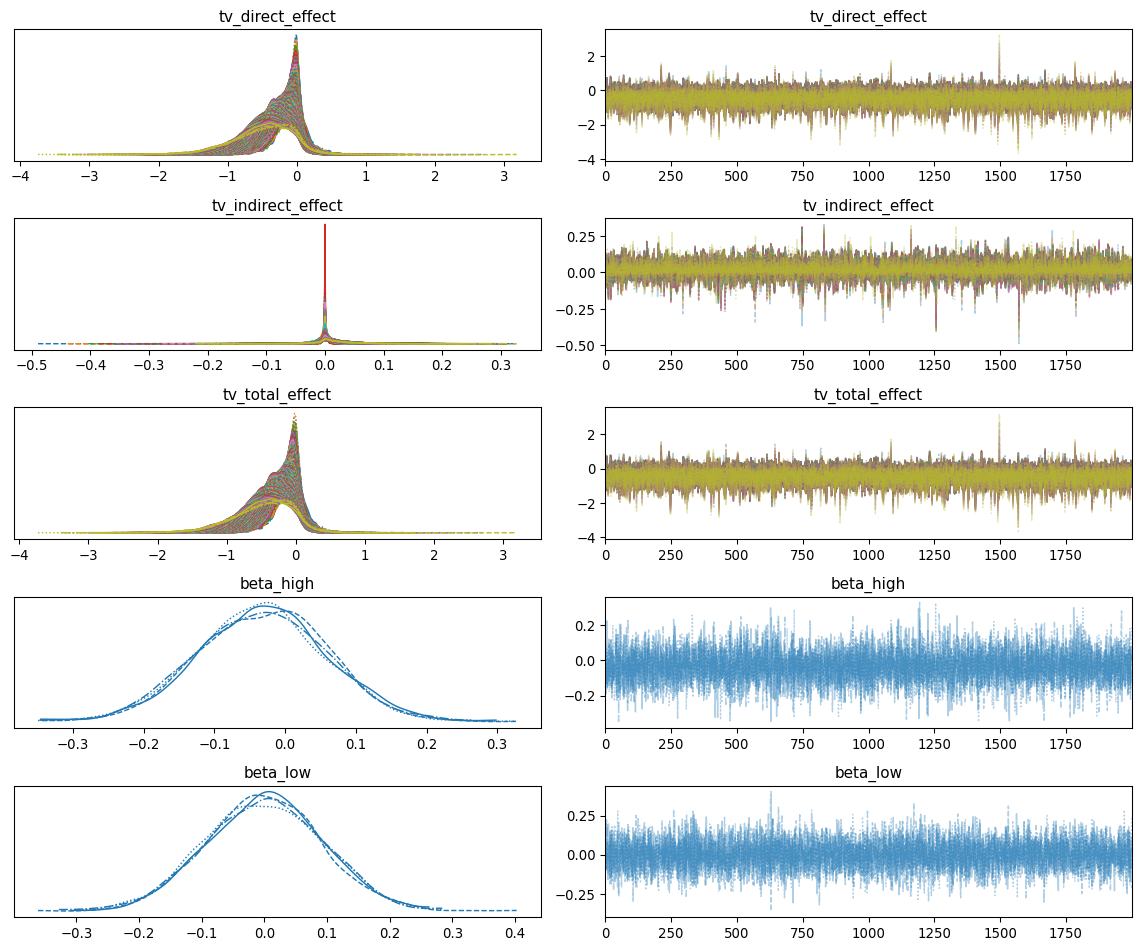

In [16]:
az.plot_trace(idata_aalen, var_names=['tv_direct_effect', 'tv_indirect_effect', 'tv_total_effect', 'beta_high', 'beta_low'], divergences=False);
plt.tight_layout()

#### Posterior Predictive Checks (PPC)
The PPC is the model's primary diagnostic tool for assessing "goodness-of-fit." By simulating new data from the posterior and comparing it to the actual observations, we ensure the model has accurately captured the data-generating process. 

The first plot on the left shows the **Mediator Outcome**. The good fit validates the autoregressive B-spline component ($X \to M$). A strong overlap indicates that the Gaussian path is correctly specified and the B-splines are capturing the mediator's temporal trend.

The second plot on the right panel confirms the "Poisson Bridge" is functioning. It checks if the simulated event counts per time bin match the observed frequency. A tight fit here confirms that your hazard intensity is neither over-smoothed nor tracking random noise.


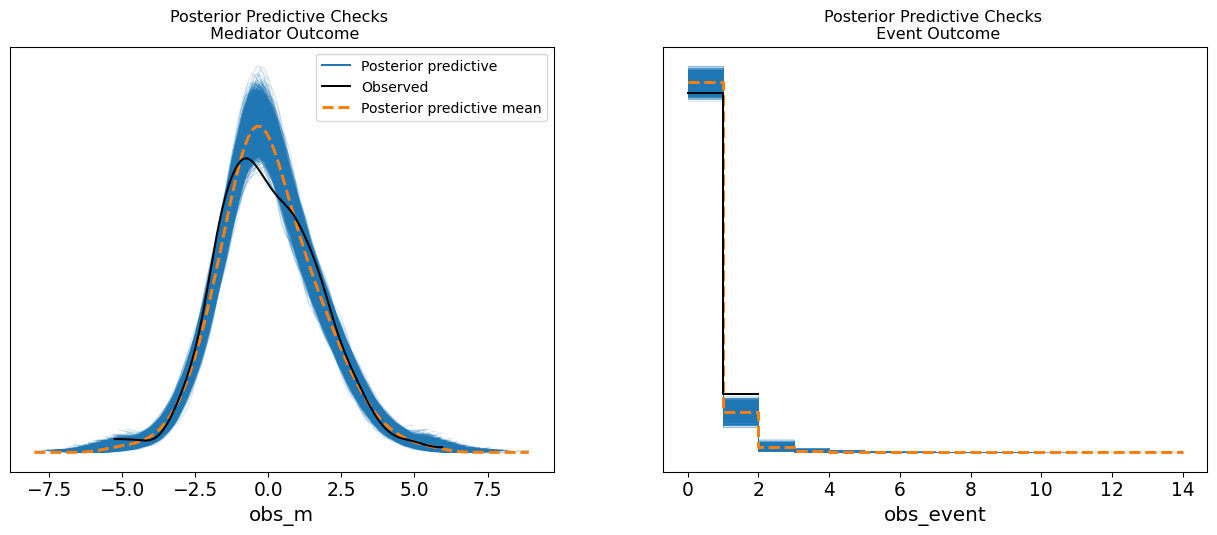

In [17]:
#| output: false
ax = az.plot_ppc(idata_aalen);
ax[0].set_title("Posterior Predictive Checks \n Mediator Outcome")
ax[1].set_title("Posterior Predictive Checks \n Event Outcome")
fig = ax[0].figure
fig.savefig("Posterior_Predictive_checks.png")

![](Posterior_Predictive_checks.png)

The model checks appear healthy, but have we actually replicated the dpasurv analysis?

#### Time-Varying Causal Effects (Log-Additive Scale)
The next plots aim to recreate the `dpasurv` analysis. They represent the **additive decomposition** of the treatment's impact within the linear predictor. Because these are plotted on the scale of the $\alpha$ coefficients, they show the "raw" causal pressure before the Softplus transformation.

* **Time-Varying Direct Effect ($\alpha_{1,t}$):** This path shows a steady downward trend into negative territory, indicating that the treatment has a progressively **protective direct effect** on the hazard. If analyzed in isolation, this would suggest the treatment is successfully reducing risk over time.
* **Time-Varying Indirect Effect ($\beta_t \cdot \alpha_{2,t}$):** In contrast, the indirect path shows a stable, materializing **harmful effect** mediated through $M$. As the study progresses, the mediator offsets the treatment's benefits, introducing a source of risk that grows in certainty (narrowing HDI).
* **Time-Varying Total Effect:** The sum of these two opposing forces. Because the harmful indirect effect partially "cancels out" the protective direct effect, the total effect appears significantly more modest—or even neutral. This reveals a **masked harmful effect**: without this decomposition, the treatment might be judged as ineffective, when in reality, it is highly effective but being undermined by the specific biological or behavioral pathway of the mediator.


In [18]:
# | code-fold: true

def plot_effects(idata, vars_to_plot, labels, scale="Log Hazard Ratio Scale"):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    color='teal'
    if scale != "Log Hazard Ratio Scale":
        color='darkred'

    for i, var in enumerate(vars_to_plot):
        # 1. Extract the posterior samples for this variable
        # Shape will be (chain * draw, time)
        post_samples = az.extract(idata, var_names=[var]).values.T
        
        # 2. Calculate the mean and the 94% HDI across the chains/draws
        mean_val = post_samples.mean(axis=0)
        hdi_val = az.hdi(post_samples, hdi_prob=0.94) # Returns [time, 2] array
        
        # 3. Plot the Mean line
        x_axis = np.arange(len(mean_val))
        axs[i].plot(x_axis, mean_val, label=labels[i], color=color, lw=2)
        
        # 4. Plot the Shaded HDI region
        axs[i].fill_between(x_axis, hdi_val[:, 0], hdi_val[:, 1], color=color, alpha=0.2, label='94% HDI')
        
        # Formatting
        axs[i].set_title(labels[i])
        axs[i].legend()
        axs[i].grid(alpha=0.3)
        axs[i].set_ylabel(scale)
    plt.tight_layout()
    return fig


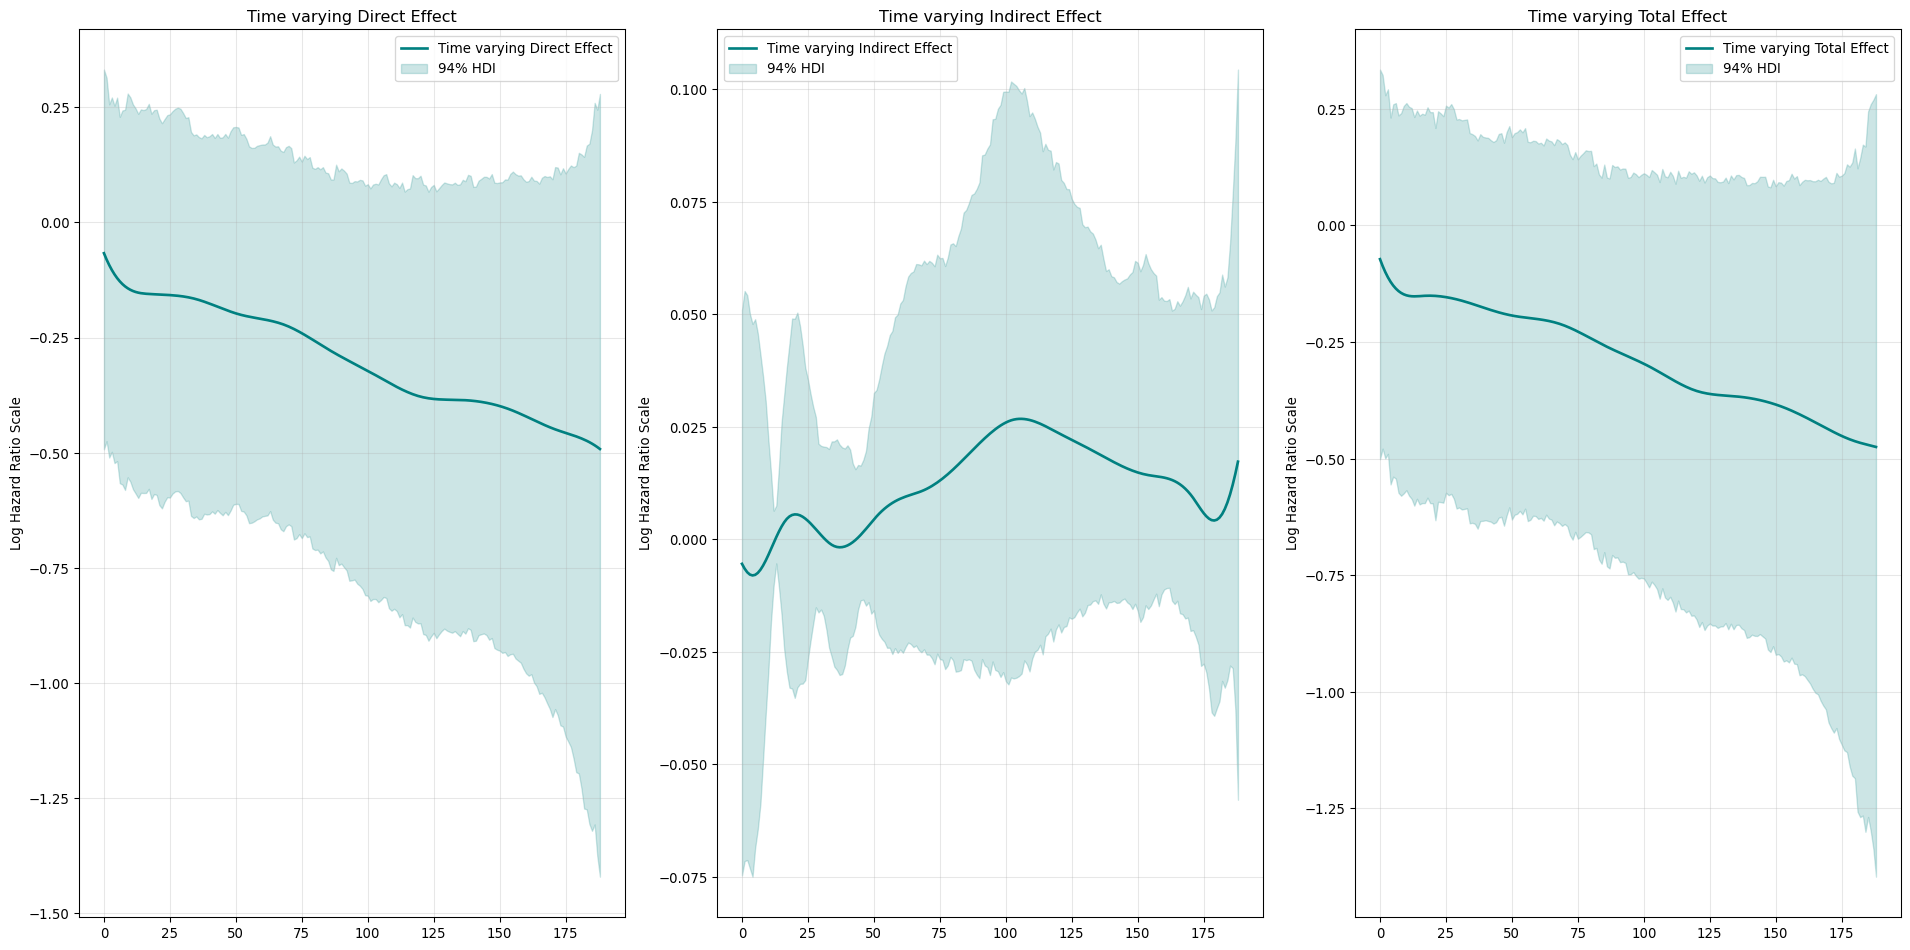

In [19]:
vars_to_plot = ['tv_direct_effect', 'tv_indirect_effect', 'tv_total_effect']
labels = ['Time varying Direct Effect', 'Time varying Indirect Effect', 'Time varying Total Effect']

plot_effects(idata_aalen, vars_to_plot, labels);

::: {.callout-tip}
### Relationship to Aalen's Additive `dpasurv`

The structure of the recovered effects in our Bayesian model closely replicates the trends seen in the frequentist `dpasurv` implementation. However, there is a notable difference in the **scale of the y-axis** and the magnitude of the trajectories. 

This divergence is expected and stems from our use of the **Softplus link function** ($f(x) = \ln(1 + \exp(x))$). While `dpasurv` typically operates on a strictly linear identity scale (which can result in negative hazards if not carefully constrained), our Bayesian model operates on a transformed scale to ensure sampling stability and physical plausibility. The Softplus scaling "squashes" values as they approach zero, meaning that while the *directional* causal story (protective direct effect vs. harmful indirect effect) remains identical, the absolute units of the cumulative effect are scaled differently to accommodate the non-linear map to the Poisson intensity.
:::

Given that the previous causal decomposition occurs on the transformed scale of the linear predictor, interpreting the raw magnitudes of the $\alpha$ coefficients can be challenging when comparing against traditional identity-scale models like `dpasurv`. To move from these internal model dynamics to a more universally interpretable metric, we calculate the Time-Varying Relative Risk (RR). By taking the ratio of the hazard with exposure and compare it with the baseline hazard.


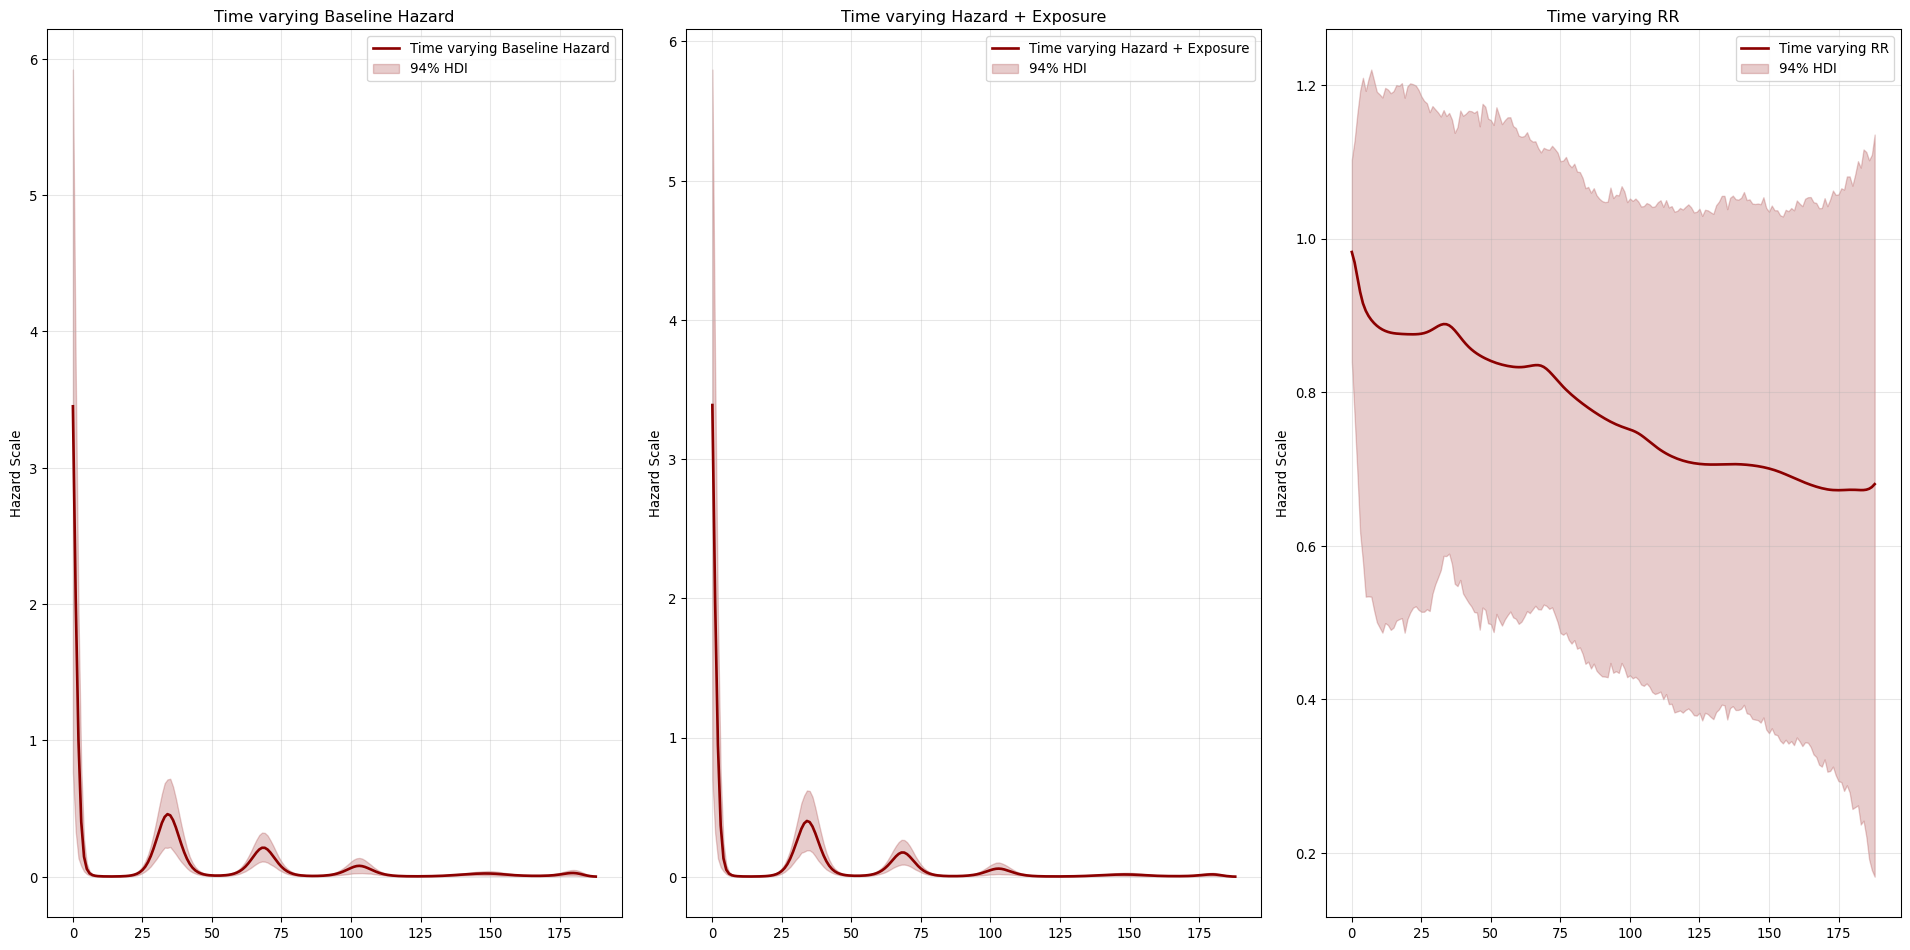

In [20]:
vars_to_plot = ['tv_baseline_hazard', 'tv_hazard_with_exposure', 'tv_RR']
labels = ['Time varying Baseline Hazard', 'Time varying Hazard + Exposure', 'Time varying RR']
plot_effects(idata_aalen, vars_to_plot, labels, scale='Hazard Scale');

This effectively "normalizes" the protective direct effects and harmful indirect effects, allowing us to visualize the net impact on the risk profile in a format familiar to survival analysis, regardless of the underlying link function or scaling required for MCMC sampling. A horizontal line at $1$ would imply a neutral treatment with no more or less protective effects. Instead, the slope indicates that the treatment becomes more protective over time. The risk for the exposed group drops by roughly $30\%$ ($RR \approx 0.7$) by the end of the observation period.

## From Time-Varying to Marginal Effects: G-Computation

Using g-computation, we simulate two counterfactual worlds—everyone treated vs. no one treated—and compare outcomes. Different journey trajectories.


In [21]:
# | output: false

trt_values = np.ones(len(df_long)).astype(int)
with aalen_dpa_model: 
    pm.set_data({'trt': trt_values})
    idata_trt1 = pm.sample_posterior_predictive(idata_aalen, return_inferencedata=True)

trt_values = np.zeros(len(df_long)).astype(int)
with aalen_dpa_model: 
    pm.set_data({'trt': trt_values})
    idata_trt0 = pm.sample_posterior_predictive(idata_aalen, return_inferencedata=True)

Sampling: [obs_event, obs_m]


Output()

Sampling: [obs_event, obs_m]


Output()

We summarise the imputed posterior distribution by describing range of probable RR scores. We clip the maximim posterior predictive distribution at 1 as scores above 1 are an artefact the Poisson likelihood, not a meaningful contribution to the rate. 


In [22]:
## Get last imputed observation per subject
last_obs = df_long.loc[df_long.groupby('subject')['bin_idx'].idxmax()]
post1 = idata_trt1['posterior_predictive']['obs_event'].sel(obs = last_obs.index)
post0 = idata_trt0['posterior_predictive']['obs_event'].sel(obs = last_obs.index)
## Clipping at one in case Poisson prediction exceeds 1. Event is binary.
rr_imputed = post1.clip(max=1).mean(dim='obs') / post0.clip(max=1).mean(dim='obs')

rr_mean = rr_imputed.mean()
rr_hdi = az.hdi(rr_imputed, hdi_prob=.5)

print(f"Imputed Mean Relative Risk {np.round(rr_mean.item(), 3)} and 50% HDI {[rr_hdi['obs_event'][0].item(), rr_hdi['obs_event'][1].item()]}")
print(f"Imputed Percent Risk Reduction of {1- np.round(rr_mean.item(), 3)}")

Imputed Mean Relative Risk 0.827 and 50% HDI [0.6716417910447761, 0.8867924528301886]
Imputed Percent Risk Reduction of 0.17300000000000004


The marginal risk ratio tells us treatment reduces events by ~17% by the end of study period. This single number, however, conceals the rich temporal story: the treatment is consistently protective (direct effect), but partially undermined by a harmful mediated pathway emerging around Day 100. The dynamic path model gives you both the summary *and* the mechanistic decomposition over time. Yet, the imputation mechanism is not merely for bookkeeping and statistical summaries. It can be extended to compute alternative causal estimands under different counterfactual settings to identify other causal estimands like the non-parametric natural direct effect. 


In [23]:
# 1. Access the posterior components
post = idata_aalen.posterior
# Get the 'Natural' mediator under X=0 from your existing trt0 idata
m_nat = az.extract(idata_trt0.posterior_predictive['obs_m']) 

# 2. Extract time-varying coefficients
# (b is the bin index for each observation in df_long)
b = df_long['bin_idx'].values
a0 = az.extract(post['alpha_0_t'].sel(time_bins=b))
a1 = az.extract(post['alpha_1_t'].sel(time_bins=b))
a2 = az.extract(post['alpha_2_t'].sel(time_bins=b))

eta_ndes = []
N = 500
for i in range(N):
    eta_nde = a0['alpha_0_t'][:, i].values + (a1['alpha_1_t'][:, i].values * 1) + (a2['alpha_2_t'][:, i].values * m_nat['obs_m'][:, i].values)
    eta_ndes.append(eta_nde)
eta_ndes = np.asarray(eta_ndes)


dt = df_long['dt'].values
hazard_nde = dt * np.log1p(np.exp(eta_ndes))
nde_events = np.asarray([np.random.poisson(hazard_nde[i, :], size=len(dt)) for i in range(N)])

ctrl_events = az.extract(idata_trt0.posterior_predictive['obs_event'])
ctrl_events = np.asarray([ctrl_events['obs_event'][:, i].values for i in range(N)])

nde_rr = np.mean(nde_events[:, last_obs.index], axis=1) / np.mean(ctrl_events[:, last_obs.index], axis=1)

# 0.75
mean_rr = np.mean(nde_rr)
print(f"Expected Natural Direct Effect as Relative Risk: {mean_rr}")
print(f"Expected Natural Direct Effect as %Risk Reduction: {1 - mean_rr}")

Expected Natural Direct Effect as Relative Risk: 0.7624798998381676
Expected Natural Direct Effect as %Risk Reduction: 0.23752010016183245


The NDE is the contrast between the outcome under treatment and the outcome under control, while holding the mediator constant at its natural value under control. By nesting the $M(0)$ potential outcome within the $Y(1)$ potential outcome, we create a "pure" experimental condition that does not exist in nature. This allows us to measure the intervention's potency while surgically removing its ability to act through the mediator. In our time-varying model, this ensures that the Direct Effect we report is the "unmediated" pressure of the treatment, isolated from the evolving dynamics of the secondary causal path.


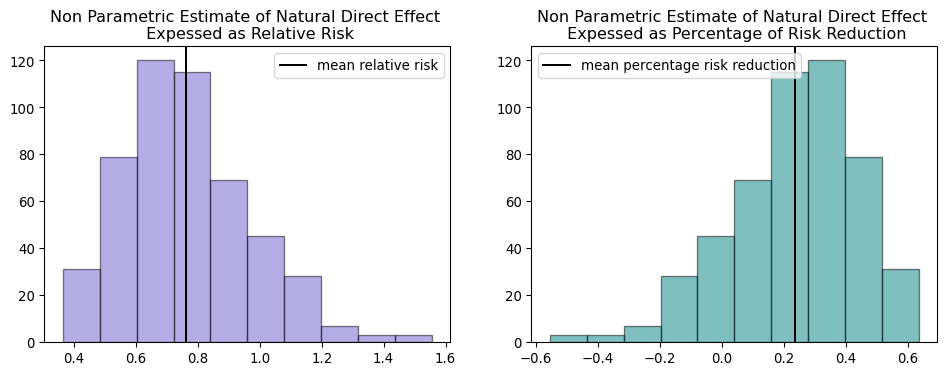

In [24]:
#| output: false
#| code-fold: true
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(nde_rr, ec='black', alpha=0.5, color='slateblue')
axs[0].axvline(mean_rr, color='k', label='mean relative risk')
axs[0].legend();
axs[0].set_title("Non Parametric Estimate of Natural Direct Effect \n Expessed as Relative Risk")
axs[1].hist(1-nde_rr, ec='black', alpha=0.5, color='teal')
axs[1].axvline(1-mean_rr, color='k', label='mean percentage risk reduction')
axs[1].legend();
axs[1].set_title("Non Parametric Estimate of Natural Direct Effect \n Expessed as Percentage of Risk Reduction");
fig.savefig("NonparametricEstimateNDE.png");

![](NonparametricEstimateNDE.png)

The imputaton tooling is an invitation to explore possible worlds and trace the consequences of counterfactual decisions. 

### How we got here

When Odysseus finally reached Ithaca, his journey home had taken ten years—not because the distance was far, but because the voyage itself transformed him and his circumstances. This is the fundamental insight of dynamic path analysis: outcomes are not destinations; they are cumulative consequences of time-varying processes.

In this post, we've built a complete Bayesian implementation of Aalen's Dynamic Path Model that moves beyond the proportional hazards paradigm. Rather than assuming a treatment has a constant multiplicative effect throughout a study, we've allowed direct, indirect, and total effects to evolve as smooth functions of time using B-spline basis expansions. This shift from multiplicative to additive models is more than technical—it's conceptual. Effects become **increments to risk** rather than multipliers, making them naturally interpretable as causal estimands. Time-varying coefficients directly answer: "What is the cumulative risk attributable to this exposure *right now*?" And crucially, direct and indirect effects become **sums of paths traced through time**.

By adopting the "Poisson Bridge," we've established a fully generative model where both baseline hazards and time-varying effects are explicit parameters. This additivity, combined with the Softplus link function (log1pexp), gives us a model that is both theoretically grounded in causal inference and practically stable for MCMC sampling. 

## Conclusion: The Journey Is the Model

The payoff is substantial: most causal inference treats time as a container in which effects happen. Dynamic path analysis treats time as the medium through which causation propagates. When effects accumulate additively over time, direct and indirect paths become visible as distinct trajectories. It shows its value when effects attenuate or strengthen over time e.g. drug effectiveness that fades, policies with delayed impacts, interventions with "honeymoon periods". This reveals a category of causal phenomena invisible to endpoint analysis: treatments that work but are undermined, treatments that fail early but succeed late, and mediators that flip from protective to harmful as the process unfolds. The cost of ignoring temporal dynamics is not just statistical inefficiency—it's misdiagnosis of mechanism, which means intervening on the wrong target at the wrong time.

Odysseus's journey reminds us that understanding how we arrive at outcomes is often more valuable than simply knowing whether we arrived. In causal inference, this means moving beyond static treatment effects to models that capture the full temporal dynamics of intervention, mediation, and risk. The tools presented here—B-splines for smooth time-varying effects, the Poisson Bridge for Bayesian inference, and dynamic path decomposition for causal interpretation—provide a principled way to track these journeys. Whether you're evaluating a New Year's resolution, a clinical trial, or a policy intervention, this framework lets you see not just the destination, but the evolving forces that shaped the voyage.

#### Further Reading

This implementation builds on Fosen et al.'s 2006 paper "Dynamic path analysis—a new approach to analyzing time-dependent covariates" (*Lifetime Data Analysis*) and Aalen's foundational 1989 work on additive regression models for survival data (*Statistics in Medicine*) and the discussion of causal inference in Brostrom's _Event History Analysis with R_. We aim to replicate, as close as feasible, the results reported in [`dpasurv`](https://opensource.nibr.com/dpasurv/articles/dpa.html#dynamic-path-analysis-1)
